## Load parquet

In [1]:
%matplotlib widget
%matplotlib inline

In [2]:

import pandas as pd

import matplotlib.pyplot as plt
import pandas_ta as ta

In [3]:
df = pd.read_parquet("data.parquet")

In [4]:
df.head()

,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0
2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0
3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0
4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0


In [5]:
df.groupby("name").count()

,id,figi,ts,open_price,close_price,high_price,low_price,volume
name,,,,,,,,
AT&T,101134,101134,101134,101134,101134,101134,101134,101134
Apple,119367,119367,119367,119367,119367,119367,119367,119367
JPMorgan,85536,85536,85536,85536,85536,85536,85536,85536


## Analyze single stock

### Create dataset with sliding averages

In [6]:
sliding_window_df = df[df["id"] == 1].reset_index()

In [7]:
sliding_window_df.head()

,index,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0
2,2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0
3,3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0
4,4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0


In [8]:

# List of all indicators
sliding_window_df.ta.indicators()


Pandas TA - Technical Analysis Indicators - v0.2.23b0
Total Indicators: 123
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_doji, cdl_inside, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, decay, decreasing, dema, donchian, dpo, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, ichimoku, increasing, inertia, kama, kc, kdj, kst, kurtosis, linreg, log_return, long_run, macd, mad, massi, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvt, pwma, qstick, quantile, rma, roc, rsi, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, stdev, stoch, stochrsi, supertrend, swma, t3, tema, thermo, trend_return, trima, trix, true_range, tsi, ttm_trend, ui, uo, variance, vortex, vp, vwap, vwma, wcp, willr, wma, zlma, zscore


Add metrics

In [9]:
# Add MACD
sliding_window_df.ta.macd(append=True)

# Add RSI
sliding_window_df.ta.rsi(14, append=True)

# Add MFI
sliding_window_df.ta.mfi(14, append=True)

sliding_window_df.head()

,index,name,id,figi,ts,open_price,close_price,high_price,low_price,volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,MFI_14
0,0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0,NaN,NaN,NaN,NaN,NaN
1,1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0,NaN,NaN,NaN,NaN,NaN
2,2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0,NaN,NaN,NaN,100.000000,NaN
3,3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0,NaN,NaN,NaN,90.697674,NaN
4,4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0,NaN,NaN,NaN,94.688458,NaN


In [10]:
sliding_window_df.describe()

,index,id,open_price,close_price,high_price,low_price,volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,MFI_14
count,85536.000000,85536.0,85536.000000,85536.000000,85536.000000,85536.000000,85536.000000,85511.000000,85511.000000,85528.000000,85534.000000,8.552300e+04
mean,160824.458064,1.0,108.869357,108.868067,108.965903,108.769106,17384.196935,0.000945,-0.000004,0.000949,50.000697,4.893427e+01
std,89950.782007,0.0,12.836169,12.837386,12.816483,12.857599,23507.344659,0.331436,0.107139,0.309003,12.180194,2.128730e+01
min,0.000000,1.0,77.570000,77.250000,78.640000,76.930000,1.000000,-5.099767,-2.370230,-4.474312,5.623387,-2.910913e-10
25%,82402.750000,1.0,99.390000,99.390000,99.490000,99.280000,79.000000,-0.113025,-0.036314,-0.107513,41.880198,3.478548e+01
50%,169457.500000,1.0,108.110000,108.110000,108.200000,108.020000,12355.000000,0.000336,-0.000516,0.000513,50.136372,4.895652e+01
75%,238955.250000,1.0,115.510000,115.500000,115.590000,115.430000,24494.250000,0.120574,0.036310,0.115109,58.260839,6.299376e+01
max,305699.000000,1.0,141.240000,141.240000,141.240000,141.240000,515849.000000,3.564853,1.535910,3.143031,100.000000,1.000000e+02


Add RSI oversold and overbought

In [11]:
RSI_oversold_threshold = 30
RSI_overbouht_threshold = 70

sliding_window_df["RSI_oversold"] = sliding_window_df["RSI_14"] <= RSI_oversold_threshold
sliding_window_df["RSI_overbought"] = sliding_window_df["RSI_14"] >= RSI_overbouht_threshold

Add MFI oversold

In [12]:
MFI_oversold_threshold = 20
MFI_overbouht_threshold = 80

sliding_window_df["MFI_oversold"] = sliding_window_df["MFI_14"] <= MFI_oversold_threshold
sliding_window_df["MFI_overbought"] = sliding_window_df["MFI_14"] >= MFI_overbouht_threshold

Add MACD signal crossover and cross under

In [13]:
sliding_window_df["MACD_diff"] = sliding_window_df["MACD_12_26_9"].diff()
sliding_window_df["MACD_diff"] = sliding_window_df["MACD_12_26_9"].diff()
sliding_window_df["MACD_crossover"] = (sliding_window_df["MACD_diff"] > 0) & (sliding_window_df["MACD_diff"].shift() < 0)
sliding_window_df["MACD_crossunder"] = (sliding_window_df["MACD_diff"] < 0) & (sliding_window_df["MACD_diff"].shift() > 0)

In [14]:
sliding_window_df["MACD_diff"].iloc[163]

-0.4792257591043949

In [15]:
sliding_window_df["MACD_diff"].shift().iloc[163]

0.045452154704037184

In [16]:
(-0.4792257591043949 < 0) & (0.045452154704037184 > 0)

True

In [17]:
sliding_window_df.iloc[163]

index                                    701
name                                JPMorgan
id                                         1
figi                            BBG000DMBXR2
ts                 2018-02-05 23:55:00+00:00
open_price                             108.3
close_price                            108.3
high_price                             108.3
low_price                              108.3
volume                                    10
MACD_12_26_9                        -0.87233
MACDh_12_26_9                       -0.43266
MACDs_12_26_9                       -0.43967
RSI_14                               16.4157
MFI_14                               48.9363
RSI_oversold                            True
RSI_overbought                         False
MFI_oversold                           False
MFI_overbought                         False
MACD_diff                          -0.479226
MACD_crossover                         False
MACD_crossunder                         True
Name: 163,

Show MACD RSI

In [18]:
def color_zone(ax, points, alpha, color):
    start_point = 0
    end_point = 0
    for x in points:
        if start_point == 0:
            start_point = x
            end_point = x + 1
        else:
            if end_point == x:
                # Continue
                end_point += 1
            else:
                # Draw and reset
                ax.axvspan(start_point, end_point, alpha=alpha, color=color)
                start_point = 0
                end_point = 0

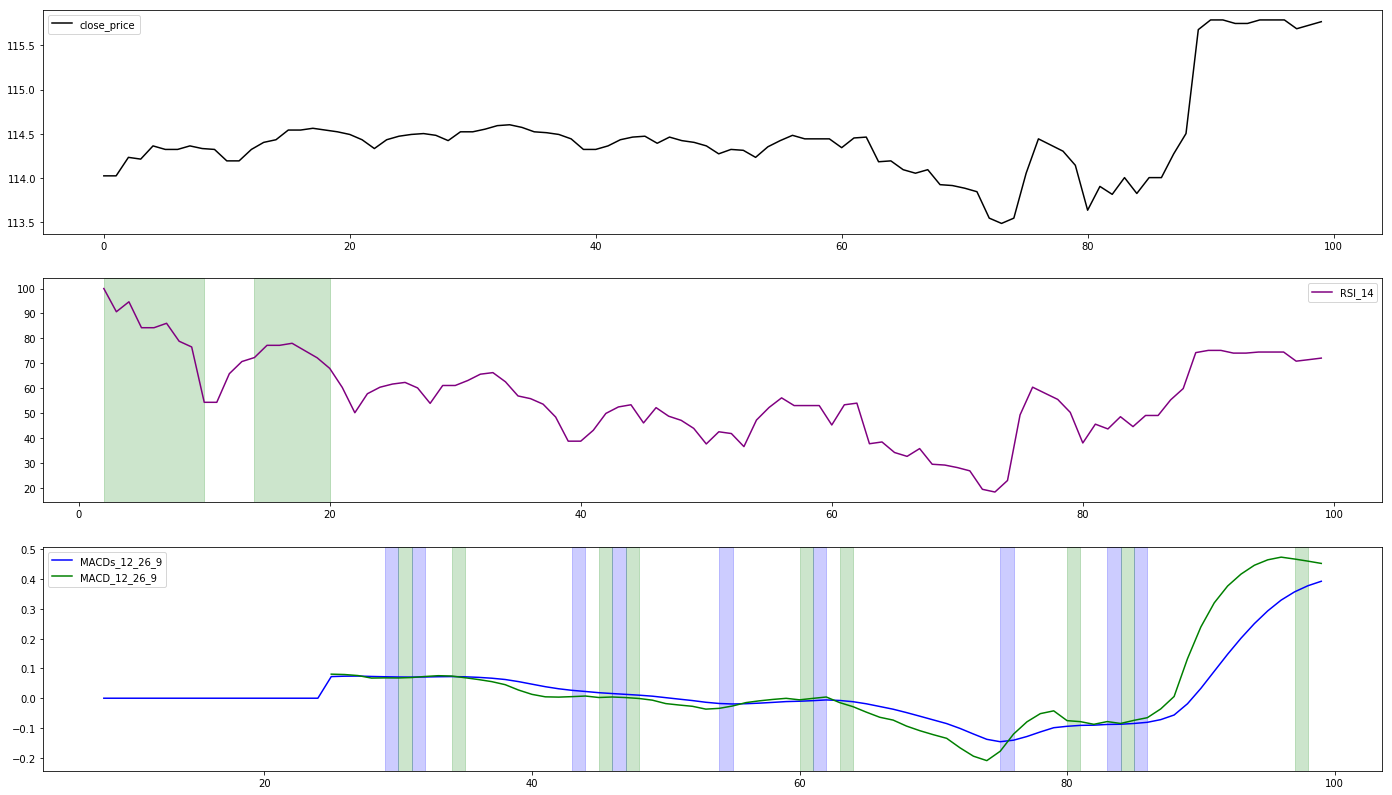

In [19]:
plot_df = sliding_window_df.iloc[0:100]

plt.figure(figsize=(24,14))
plt.subplot(3, 1, 1)
plot_df["close_price"].plot(color="black")
plt.legend()

plt.subplot(3, 1, 2)
ax1 = plot_df["RSI_14"].plot(color="purple")
# Show oversold zone
color_zone(ax1, plot_df[plot_df["RSI_oversold"]].index, 0.2, "blue")
# Show overbought zone
color_zone(ax1, plot_df[plot_df["RSI_overbought"]].index, 0.2, "green")
plt.legend()

plt.subplot(3, 1, 3)
# plot_df["MACDh_12_26_9"].plot(color="red",kind="bar")
plot_df["MACDs_12_26_9"].plot(color="blue")
ax3 = plot_df["MACD_12_26_9"].plot(color="green")
# Show crossover moments
for x in plot_df[plot_df["MACD_crossover"]].index:
    ax3.axvspan(x, x+1, alpha=0.2, color="blue")      
# Show crossunder moments
for x in plot_df[plot_df["MACD_crossunder"]].index:
    ax3.axvspan(x, x+1, alpha=0.2, color="green")
plt.legend()

# Create manual bot

In [20]:
# Create dataset for bot
bot_df = sliding_window_df[["open_price","close_price","high_price","low_price","volume","MACD_12_26_9","RSI_14"]]
bot_df = bot_df.rename(columns={"MACD_12_26_9":"MACD","RSI_14":"RSI"})
bot_df.head()

,open_price,close_price,high_price,low_price,volume,MACD,RSI
0,114.02,114.02,114.02,114.02,6.0,NaN,NaN
1,114.02,114.02,114.02,114.02,10.0,NaN,NaN
2,114.20,114.23,114.26,114.16,76837.0,NaN,100.000000
3,114.37,114.21,114.39,114.19,34299.0,NaN,90.697674
4,114.33,114.36,114.41,114.31,27240.0,NaN,94.688458


In [26]:
from bot import TradingBot

# Test bot
bot = TradingBot(stop_loss=0.1)

bot.reset()

for index, data in bot_df.iterrows():
    bot.process(data)

8
Step: 40687 Sell with price=135.352815 and profit 2.17%
Overall Profit 190.72%
Step: 40779 Buy with price=133.400000
Step: 40849 Sell with price=135.201122 and profit 1.35%
Overall Profit 192.07%
Step: 41215 Buy with price=134.300000
Step: 41233 Sell with price=136.761656 and profit 1.83%
Overall Profit 193.90%
Step: 41284 Buy with price=136.640310
Step: 41300 Sell with price=138.224818 and profit 1.16%
Overall Profit 195.06%
Step: 41445 Buy with price=137.779991
Step: 41742 Sell with price=137.786088 and profit 0.00%
Overall Profit 195.06%
Step: 41790 Buy with price=137.395565
Step: 41818 Sell with price=138.124892 and profit 0.53%
Overall Profit 195.59%
Step: 42151 Buy with price=138.117064
Step: 42274 Sell with price=139.234411 and profit 0.81%
Overall Profit 196.40%
Step: 42375 Buy with price=138.945120
Step: 42520 Sell with price=139.010000 and profit 0.05%
Overall Profit 196.45%
Step: 42603 Buy with price=139.569825
Step: 42638 Sell with price=140.427991 and profit 0.61%
Overal